<a href="https://colab.research.google.com/github/yepuv1/primality/blob/master/primality_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primality test using ANN.

The aim is to train a ANN Model on a small sample of primes from a finite prime numbers set.  In this notebook, I am generating the primes within 1M, which has 78K primes. The model is trained on a sample of 5k from this 78k prime set. What is interesting is that the model accuracy is 99.6% when testing for primality of the 78k primes. The accuracy drops rapidly for samples outside this 78k range of primes.



In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import sympy
from tensorflow.python.framework import ops
from sympy import primerange, sieve, composite, prime
import pickle
import timeit
%matplotlib inline
np.random.seed(1)

In [2]:
print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.19.0
Found GPU at: /device:GPU:0


In [3]:
def convert_dec2bin(num_list,feature_size):
  p_x = None
  for p in num_list:
    pb = bin(p)[2:].zfill(32)
    li = [ int(i) for i in pb]
    a1 = np.array(li).reshape((feature_size,1))
    if p_x is None:
      p_x = a1
    else:
      p_x = np.concatenate((p_x, a1), axis=1)
  return p_x

In [4]:
def generate_sequence_primes(between):
  start, end = between
  p_num = [i for i in primerange(start, end)]
  return p_num, len(p_num)

In [5]:
def generate_random_primes(size, primes):
  le = len(primes)
  p_num = [primes[i] for i in np.random.randint(le , size=size)]
  return p_num, size

In [6]:
def generate_composite(size):
  c_num = np.random.randint(10000000, size=size)
  return c_num, size


In [7]:
def generate_x_y(primes, composites=None, feature_size=32):
  c_examples_size = 0
  p_examples_size = 0

  only_primes = False
  if composites is None:
    only_primes = True

  p_examples_size = len(primes)
  p_x = convert_dec2bin(primes, feature_size)
  p_y = np.ones(shape=(1,p_examples_size), dtype=np.int32)

  X = None
  Y = None

  if not only_primes:
    c_examples_size = len(composites)
    c_x = convert_dec2bin(composites, feature_size)
    c_y = np.zeros(shape=(1,c_examples_size), dtype=np.int32)
    X = np.concatenate((c_x, p_x), axis=1)
    size = p_examples_size + c_examples_size
    Y = np.append(c_y, p_y).reshape((1, size))

  else:
    X = p_x
    Y = p_y
    size = p_examples_size

  return X, Y, size


In [18]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j)
                     will be 1.

    Arguments:
    labels -- vector containing the labels
    C -- number of classes, the depth of the one hot dimension

    Returns:
    one_hot -- one hot matrix
    """

    C = tf.constant(dtype=tf.int32, name="C", value=C)
    one_hot_matrix = tf.one_hot(labels, depth=C, axis=0)
    one_hot = one_hot_matrix.numpy()

    return one_hot



In [9]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.

    Arguments:
    n_x -- scalar, size of input vector
    n_y -- scalar, number of classes (from 0 to 1, so -> 2)

    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"

    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.placeholder(tf.float32, shape=(n_x, None))
    Y = tf.placeholder(tf.float32, shape=(n_y, None))


    return X, Y

In [10]:
def initialize_parameters(dic_of_layer_sizes):
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 2]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]

    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """

    tf.set_random_seed(1)


    parameters ={}
    for key, value in dic_of_layer_sizes.items():
      print(key)
      print(value)
      parameters[key]=tf.get_variable(key, value, initializer = tf.contrib.layers.xavier_initializer(seed = 1))


    return parameters

In [11]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR ->  SOFTMAX

    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    Z1 = tf.add(tf.matmul(W1, X), b1)  # LINEAR
    A1 = tf.nn.relu(Z1)                # RELU
    Z2 = tf.add(tf.matmul(W2, A1), b2) # LINEAR

    return Z2

In [12]:
def compute_cost(Z3, Y):
    """
    Computes the cost

    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3

    Returns:
    cost - Tensor of the cost function
    """

    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))


    return cost

In [13]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)

    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

In [20]:
def model(X_train, Y_train, X_test, Y_test,dic_of_layer_sizes,learning_rate = 0.0001,
          num_epochs = 1024, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.

    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    dic_of_layer_sizes - dictionary of W<n> b<n> sizes as [x,y]
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs

    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """


    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        try:
            for device in physical_devices:
                tf.config.experimental.set_memory_growth(device, True)
            # You can also set specific visible devices if needed, e.g.
            # tf.config.set_visible_devices(physical_devices[0], 'GPU')
        except RuntimeError as e:
            # Memory growth must be set at program startup
            print(e)

    with tf.device('/gpu:0'):

      ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
      tf.set_random_seed(1)                             # to keep consistent results
      seed = 3                                          # to keep consistent results
      (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
      n_y = Y_train.shape[0]                            # n_y : output size
      costs = []                                        # To keep track of the cost

      # Create Placeholders of shape (n_x, n_y)
      X, Y = create_placeholders(n_x, n_y)

      # Initialize parameters
      parameters = initialize_parameters(dic_of_layer_sizes)

      # Forward propagation: Build the forward propagation in the tensorflow graph
      Z3 = forward_propagation(X=X, parameters=parameters)

      # Cost function: Add cost function to tensorflow graph
      cost = compute_cost(Y=Y,Z3=Z3)

      # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
      optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)


      # Initialize all the variables
      init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session(config=config) as sess:

        # Run the initialization
        sess.run(init)

        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch

                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).

                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})

                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))

        return parameters

## Generate Primes (2, 1000000)


In [15]:
PRIMES_FILENAME = "1_million_primes.p"
def save_primes(file):
  p_num = [i for i in primerange(2, 1000000)]
  pickle.dump( p_num, open(file, "wb" ))
  return p_num

def load_primes(file):
 return pickle.load(open(file, "rb" ))

PRIMES = save_primes(PRIMES_FILENAME)

In [16]:
print(len(PRIMES))

78498


## Model Training

1.   Sample 5000 primes from PRIMES generated above
2.   Generate 5000 composite numbers
3.   Sample 100 primes from PRIMES  for dev and make sure they are not in Training set.


number of training examples = 10000
number of test examples = 200
X_train shape: (32, 10000)
Y_train shape: (2, 10000)
X_test shape: (32, 200)
Y_test shape: (2, 200)
Physical devices cannot be modified after being initialized


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Starting Keras Model Training...
Epoch 1/1500
Epoch 2/1500


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


Epoch 3/1500
Epoch 4/1500
Epoch 5/1500
Epoch 6/1500
Epoch 7/1500
Epoch 8/1500
Epoch 9/1500
Epoch 10/1500
Epoch 11/1500
Epoch 12/1500
Epoch 13/1500
Epoch 14/1500
Epoch 15/1500
Epoch 16/1500
Epoch 17/1500
Epoch 18/1500
Epoch 19/1500
Epoch 20/1500
Epoch 21/1500
Epoch 22/1500
Epoch 23/1500
Epoch 24/1500
Epoch 25/1500
Epoch 26/1500
Epoch 27/1500
Epoch 28/1500
Epoch 29/1500
Epoch 30/1500
Epoch 31/1500
Epoch 32/1500
Epoch 33/1500
Epoch 34/1500
Epoch 35/1500
Epoch 36/1500
Epoch 37/1500
Epoch 38/1500
Epoch 39/1500
Epoch 40/1500
Epoch 41/1500
Epoch 42/1500
Epoch 43/1500
Epoch 44/1500
Epoch 45/1500
Epoch 46/1500
Epoch 47/1500
Epoch 48/1500
Epoch 49/1500
Epoch 50/1500
Epoch 51/1500
Epoch 52/1500
Epoch 53/1500
Epoch 54/1500
Epoch 55/1500
Epoch 56/1500
Epoch 57/1500
Epoch 58/1500
Epoch 59/1500
Epoch 60/1500
Epoch 61/1500
Epoch 62/1500
Epoch 63/1500
Epoch 64/1500
Epoch 65/1500
Epoch 66/1500
Epoch 67/1500
Epoch 68/1500
Epoch 69/1500
Epoch 70/1500
Epoch 71/1500
Epoch 72/1500
Epoch 73/1500
Epoch 74/1500

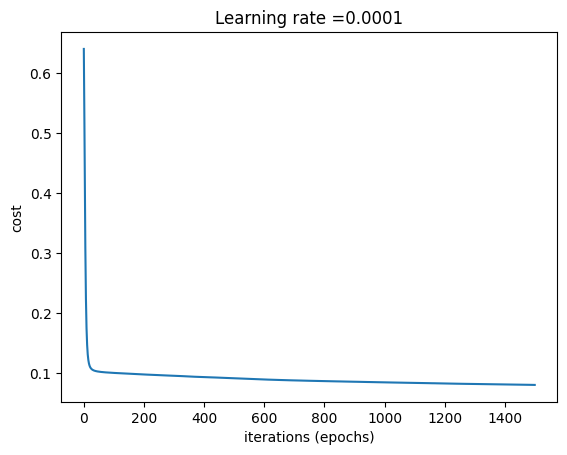

Parameters have been trained!
Train Accuracy: 0.9753000140190125
Test Accuracy: 0.9449999928474426


In [23]:
def main():
  examples_size = 5000
  c, size = generate_composite(examples_size)
  p, size = generate_random_primes(examples_size,PRIMES)
  s_p_train = set(p)
  X_train, Y_train, training_size = generate_x_y(p,c)


  examples_size = 100
  c, size = generate_composite(examples_size)
  p, size = generate_random_primes(examples_size,PRIMES)

  # remove the primes common for both test and train
  s_p_test = set(p)
  s_p_test = s_p_test - s_p_train
  X_test, Y_test, test_size = generate_x_y(list(s_p_test),c)

  Y_train = one_hot_matrix(Y_train.reshape(training_size), 2)
  Y_test = one_hot_matrix(Y_test.reshape(test_size), 2)


  print ("number of training examples = " + str(X_train.shape[1]))
  print ("number of test examples = " + str(X_test.shape[1]))
  print ("X_train shape: " + str(X_train.shape))
  print ("Y_train shape: " + str(Y_train.shape))
  print ("X_test shape: " + str(X_test.shape))
  print ("Y_test shape: " + str(Y_test.shape))

  dic_of_layer_sizes ={
      "W1":[64,32],
      "b1":[64,1],
      "W2":[2,64],
      "b2":[2,1]
  }

  parameters = model_tf2(
      X_train,
      Y_train,
      X_test,
      Y_test,
      dic_of_layer_sizes,
      num_epochs=1500,
      minibatch_size=64
  )
  return parameters

parameters = main()

##  Inference - Random sample test.

Test for random sample of primes  of sizes 10k to 50k from the population PRIMES


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


(32, 10000)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.9976
(32, 15000)
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.9982
(32, 20000)
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.9985
(32, 25000)
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.99828
(32, 30000)
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.9975333
(32, 35000)
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.998
(32, 40000)
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Accuracy: 0.997775
(32, 45000)
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Accuracy: 0.9979111


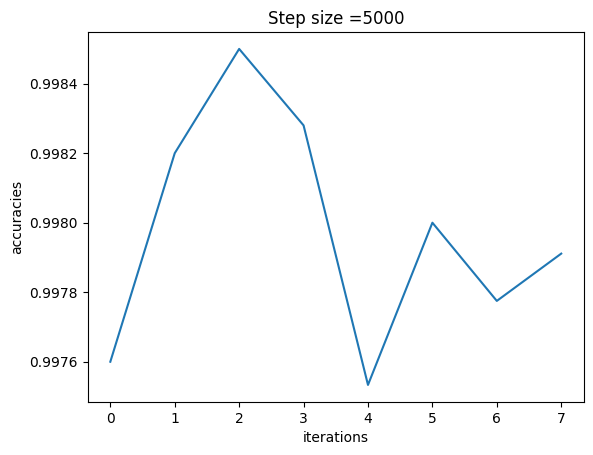

CPU times: user 1min 31s, sys: 25.4 s, total: 1min 57s
Wall time: 1min 55s


In [26]:
%%time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

start = 10000
end = 50000
step_size = 5000

accuracies = []

# The 'parameters' object is a dictionary of NumPy arrays (W1, b1, W2, b2, W3, b3)
# returned by the model_tf2 function. We need to reconstruct the Keras model
# and load these weights for inference.

# The trained model in `model_tf2` actually uses layer sizes 25 and 12, plus an output layer of 2.
# The input features are 32 (n_x).

inference_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32,)), # Input feature size is 32
    tf.keras.layers.Dense(25, activation='relu', name='fc1'), # First hidden layer, 25 units
    tf.keras.layers.Dense(12, activation='relu', name='fc2'), # Second hidden layer, 12 units
    tf.keras.layers.Dense(2, name='fc3') # Output layer, 2 units (n_y)
])

# Set the weights for the reconstructed model.
# Keras Dense layer kernel (weights) expects shape (input_dim, output_dim),
# and the 'parameters' from model_tf2 are already in this format.
# Keras Dense layer bias expects shape (output_dim,).
inference_model.layers[0].set_weights([
    parameters['W1'], # W1 from trained model
    parameters['b1']  # b1 from trained model
])
inference_model.layers[1].set_weights([
    parameters['W2'], # W2 from trained model
    parameters['b2']  # b2 from trained model
])
inference_model.layers[2].set_weights([
    parameters['W3'], # W3 from trained model (for fc3)
    parameters['b3']  # b3 from trained model (for fc3)
])

for p_size in range(start, end, step_size):
  p, size = generate_random_primes(p_size, PRIMES)
  X_inference, Y_inference, size = generate_x_y(p,None)
  print(X_inference.shape)

  # Convert Y to one-hot for consistency (though for evaluation we convert back to labels)
  Y_inference = one_hot_matrix(Y_inference.reshape(size), 2)

  # Transpose X_inference for Keras input: (num_examples, num_features)
  X_inference_transposed = X_inference.T

  # Get logits from the model using predict
  # .predict() returns numpy arrays by default if inputs are numpy arrays
  logits = inference_model.predict(X_inference_transposed)

  # Calculate predictions (argmax over the class dimension)
  # axis=1 for argmax across the classes in logits (num_examples, num_classes)
  res = tf.argmax(logits, axis=1)

  # Get true labels from one-hot encoded Y_inference
  # axis=0 for argmax across the one-hot dimension in Y_inference (num_classes, num_examples)
  true_labels = tf.argmax(Y_inference, axis=0)

  # Calculate the correct predictions
  correct_prediction = tf.equal(res, true_labels)
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

  calculated_accuracy = accuracy.numpy() # Get the float value from the tf.Tensor
  accuracies.append(calculated_accuracy)
  print ("Accuracy:", calculated_accuracy)

# plot the cost
plt.plot(np.squeeze(accuracies))
plt.ylabel('accuracies')
plt.xlabel('iterations')
plt.title("Step size =" + str(step_size))
plt.show()

## Inference - Sequence test.

Generate primes from 2 to 100k and test for primality.

In [ ]:
%%time
start = 2
end = 1000000
step_size = 1000

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
accuracies = []
with tf.device('/gpu:0'):
  p, size = generate_sequence_primes((start, end))
  X, Y, size = generate_x_y(p,None)
  print(X.shape)
  Y = one_hot_matrix(Y.reshape(size), 2)
  init = tf.global_variables_initializer()
with tf.Session(config=config) as session:
  session.run(init)
  z3 = forward_propagation(np.float32(X), parameters)
  p = tf.argmax(z3)
  res = session.run(p)

  # Calculate the correct predictions
  correct_prediction = tf.equal(res, tf.argmax(Y))
  # Calculate accuracy on the test set
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracies.append(accuracy.eval())
  print ("Accuracy:", accuracy.eval())




(32, 78498)
Accuracy: 0.99672604
CPU times: user 3min 37s, sys: 7.27 s, total: 3min 45s
Wall time: 3min 45s


## Inference - Accuracy

For primes out side the sample space, the accuracy drops.

In [ ]:
%%time
start = 1000000
end = 1100000
step_size = 1000

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
accuracies = []
with tf.device('/gpu:0'):
    p, size = generate_sequence_primes((start, end))
    X, Y, size = generate_x_y(p,None)
    print(X.shape)
    Y = one_hot_matrix(Y.reshape(size), 2)
    init = tf.global_variables_initializer()
    with tf.Session(config=config) as session:
      session.run(init)
      z3 = forward_propagation(np.float32(X), parameters)
      p = tf.argmax(z3)
      res = session.run(p)

      # Calculate the correct predictions
      correct_prediction = tf.equal(res, tf.argmax(Y))
      # Calculate accuracy on the test set
      accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
      accuracies.append(accuracy.eval())
      print ("Accuracy:", accuracy.eval())




(32, 7216)
Accuracy: 0.48406318
CPU times: user 1.73 s, sys: 98.9 ms, total: 1.82 s
Wall time: 1.83 s
